In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import random
import itertools

from matplotlib import pyplot as plt
from datetime import datetime

import tensorflow as tf
import torch
import sklearn
import keras
from sklearn.model_selection import train_test_split

import networkx as nx

In [2]:
# Original data sets are located at:
# https://www.kaggle.com/datasets/chadgostopp/recsys-challenge-2015
# I will use yoochoose-buys.dat and yoochoose-test.dat to test graph creation and GCN ML build-test pipeline
#
# The raw data and jupyter notebook can be found at: C:/Users/c1twc/P_CCB
# To upload to Github, you need to copy/paste jupyter notebook to OneDrive location:
# Ta-Wei - Personal/Documents/GitHub/ZTA

#buy = pd.read_csv("yoochoose-buys.csv")
#test = pd.read_csv("yoochoose-test.csv")
test = pd.read_csv('yoochoose-test.dat', header=None, names=['sessionId','timeStamp','itemId','category'], dtype={'sessionId':'int64', 'timeStamp':'object','itemId':'int64','category':'string'})
buy = pd.read_csv("yoochoose-buys.dat", header=None, names=['sessionId', 'timeStamp', 'itemId', 'price','quantity'])
click = pd.read_csv('yoochoose-clicks.dat', header=None, names=['sessionId','timeStamp','itemId','category'], dtype={'sessionId':'int64','timeStamp':'object','itemId':'int64','category':'string'})

In [3]:
# reduce the size of dataframe to 1/100 for easier processing
buy_small = buy[0:11500]
click_small = click[0:330000]
buy_unique = list(set(buy_small['sessionId']))
click_unique = list(set(click_small['sessionId']))

# Create a 'purchase' column and assign '0' or '1' to each 'sessionId'
# '0': sessionId doesn't generate 'buy'
# '1': sessionId generates a 'buy' action
# 
# There are several way to populate the results for 'purchase' column; the following way is the fastest one
#
click_small['purchase'] = click_small['sessionId'].isin(buy_unique).astype(int)

#
# using Python list comprehensive is pretty slow; don't use it if the size of data is large
#
#purchase_lst = [1 if c in buy_unique else 0 for c in click_small['sessionId']]
#click_small.insert(4, "purchase", purchase_lst, True)

C:\Users\c1twc\AppData\Local\Temp\ipykernel_12984\1812620594.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  click_small['purchase'] = click_small['sessionId'].isin(buy_unique).astype(int)


In [4]:
# Pre-processing
# Split the raw timeStamp, e.g. 2014-04-06T18:44:58.314Z, into two new columns: 'date' and 'time'

#buy_small['date'] = pd.to_datetime(buy_small['timeStamp']).dt.date
#buy_small['time'] = pd.to_datetime(buy_small['timeStamp']).dt.time 

date_lst = list(pd.to_datetime(buy_small['timeStamp']).dt.date)
time = list(pd.to_datetime(buy_small['timeStamp']).dt.time )
time_lst = [str(t) for t in time] # convert the datetime object to string with HH:MM:SS format
buy_small.insert(5, 'date', date_lst)
buy_small.insert(6, 'time', time_lst)

# Pre-processing
# Split the 'date' column into 3 new columns: 'year', 'month', and 'day'

year_lst = list(pd.to_datetime(buy_small['date']).dt.year)
month_lst = list(pd.to_datetime(buy_small['date']).dt.month)
day_lst = list(pd.to_datetime(buy_small['date']).dt.day)
buy_small.insert(7, 'year', year_lst)
buy_small.insert(8, 'month', month_lst)
buy_small.insert(9, 'day', day_lst)

# Take the 'time' string column containing HH:MM:SS string data, then split it into 3 columns: 'hour','minute',
# and 'second'
buy_small[['hour','minute','second']] = buy_small['time'].str.split(':', expand=True)

day_of_week_lst = list(pd.to_datetime(buy_small['date']).dt.day_name())
buy_small.insert(13, 'day_of_week', day_of_week_lst, True)


C:\Users\c1twc\AppData\Local\Temp\ipykernel_12984\932903342.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_small[['hour','minute','second']] = buy_small['time'].str.split(':', expand=True)
C:\Users\c1twc\AppData\Local\Temp\ipykernel_12984\932903342.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_small[['hour','minute','second']] = buy_small['time'].str.split(':', expand=True)
C:\Users\c1twc\AppData\Local\Temp\ipykernel_12984\932903342.py:25: SettingWithCopyWarning: 
A value is trying to b

In [5]:
buy_small.loc[buy_small['day_of_week'] == 'Sunday', 'dow'] = int(7)
buy_small.loc[buy_small['day_of_week'] == 'Monday', 'dow'] = int(1)
buy_small.loc[buy_small['day_of_week'] == 'Tuesday', 'dow'] = int(2)
buy_small.loc[buy_small['day_of_week'] == 'Wednesday', 'dow'] = int(3)
buy_small.loc[buy_small['day_of_week'] == 'Thursday', 'dow'] = int(4)
buy_small.loc[buy_small['day_of_week'] == 'Friday', 'dow'] = int(5)
buy_small.loc[buy_small['day_of_week'] == 'Saturday', 'dow'] = int(6)

buy_small = buy_small.drop(['timeStamp','date','time'], axis=1)

C:\Users\c1twc\AppData\Local\Temp\ipykernel_12984\2735030360.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buy_small.loc[buy_small['day_of_week'] == 'Sunday', 'dow'] = int(7)


In [6]:
buy_small.head()

,sessionId,itemId,price,quantity,year,month,day,hour,minute,second,day_of_week,dow
0,420374,214537888,12462,1,2014,4,6,18,44,58.314000,Sunday,7.0
1,420374,214537850,10471,1,2014,4,6,18,44,58.325000,Sunday,7.0
2,281626,214535653,1883,1,2014,4,6,09,40,13.032000,Sunday,7.0
3,420368,214530572,6073,1,2014,4,4,06,13,28.848000,Friday,5.0
4,420368,214835025,2617,1,2014,4,4,06,13,28.858000,Friday,5.0


In [10]:
#<validation code>

day_of_week = list(set(buy_small['day_of_week']))

print(day_of_week)

day_of_week_df = []

for d in day_of_week:
    day_of_week_df.append(buy_small.loc[buy_small['day_of_week']==d])

for i in range(7):
#    print(day_of_week[i], '-->', '\t', len(day_of_week_df[i].index), 'sessions') # yield the same result as that of shape[0]
    print(day_of_week[i], '-->', '\t', day_of_week_df[i].shape[0], 'sessions')


['Sunday', 'Wednesday', 'Thursday', 'Saturday', 'Monday', 'Friday', 'Tuesday']
Sunday --> 	 2652 sessions
Wednesday --> 	 1293 sessions
Thursday --> 	 1556 sessions
Saturday --> 	 1560 sessions
Monday --> 	 1623 sessions
Friday --> 	 1196 sessions
Tuesday --> 	 1620 sessions


In [11]:
click_small.head()

,sessionId,timeStamp,itemId,category,purchase
0,1,2014-04-07T10:51:09.277Z,214536502,0,0
1,1,2014-04-07T10:54:09.868Z,214536500,0,0
2,1,2014-04-07T10:54:46.998Z,214536506,0,0
3,1,2014-04-07T10:57:00.306Z,214577561,0,0
4,2,2014-04-07T13:56:37.614Z,214662742,0,0


In [12]:
buy_small.head()

,sessionId,itemId,price,quantity,year,month,day,hour,minute,second,day_of_week,dow
0,420374,214537888,12462,1,2014,4,6,18,44,58.314000,Sunday,7.0
1,420374,214537850,10471,1,2014,4,6,18,44,58.325000,Sunday,7.0
2,281626,214535653,1883,1,2014,4,6,09,40,13.032000,Sunday,7.0
3,420368,214530572,6073,1,2014,4,4,06,13,28.848000,Friday,5.0
4,420368,214835025,2617,1,2014,4,4,06,13,28.858000,Friday,5.0


# ML Testing
## Assumption:
### (1) classification problem using supervised ML
### (2) feature vector: [itemId, month, day, hour, minute, dow]
### (3) prediction: [purchase]

In [112]:
# Need to import the following library:
# from sklearn.model_selection import train_test_split
# 
# Reference:
# https://sparkbyexamples.com/pandas/pandas-create-test-and-train-samples-from-dataframe/
#
Click_train, Click_test = train_test_split(click_small, test_size=0.2, random_state=42)
Buy_train, Buy_test = train_test_split(buy_small, test_size=0.2, random_state=42)

## SessionId-ItemId Graph using NetworkX

In [14]:
# Use a small subset of buy_small for testing
#
buy_small_small = buy_small[0:8000]

G = nx.Graph()
num_nodes = buy_small_small.shape[0]

# Create trasaction nodes -- each row, representing one specific action, is treated as a separated node
214761480
for i in range(num_nodes):
    G.add_node(i, sessionId=buy_small['sessionId'][i],
              itemId=buy_small['itemId'][i],
              price=buy_small['price'][i],
              quantity=buy_small['quantity'][i],
              year=buy_small['year'][i],
              month=buy_small['month'][i],
              day=buy_small['day'][i],
              hour=buy_small['hour'][i],
              minute=buy_small['minute'][i],
              second=buy_small['second'][i],
              day_of_week=buy_small['day_of_week'][i])


In [16]:
# Create 'Item' node with attribute of 'itemId'
item = list(set(buy_small['itemId']))

G_item = nx.Graph()

num_item_nodes = len(item)

for i in range(num_item_nodes):
    G_item.add_node(i, itemId=item[i], color='red')

In [17]:
for i in range(num_nodes):
    if G.nodes[i]['itemId'] in item:
        idx = item.index(G.nodes[i]['itemId'])
        G.add_edge(G.nodes[i]['sessionId'], G_item.nodes[idx]['itemId'])
#        print(G.nodes[i]['sessionId'], G_item.nodes[idx]['itemId'])

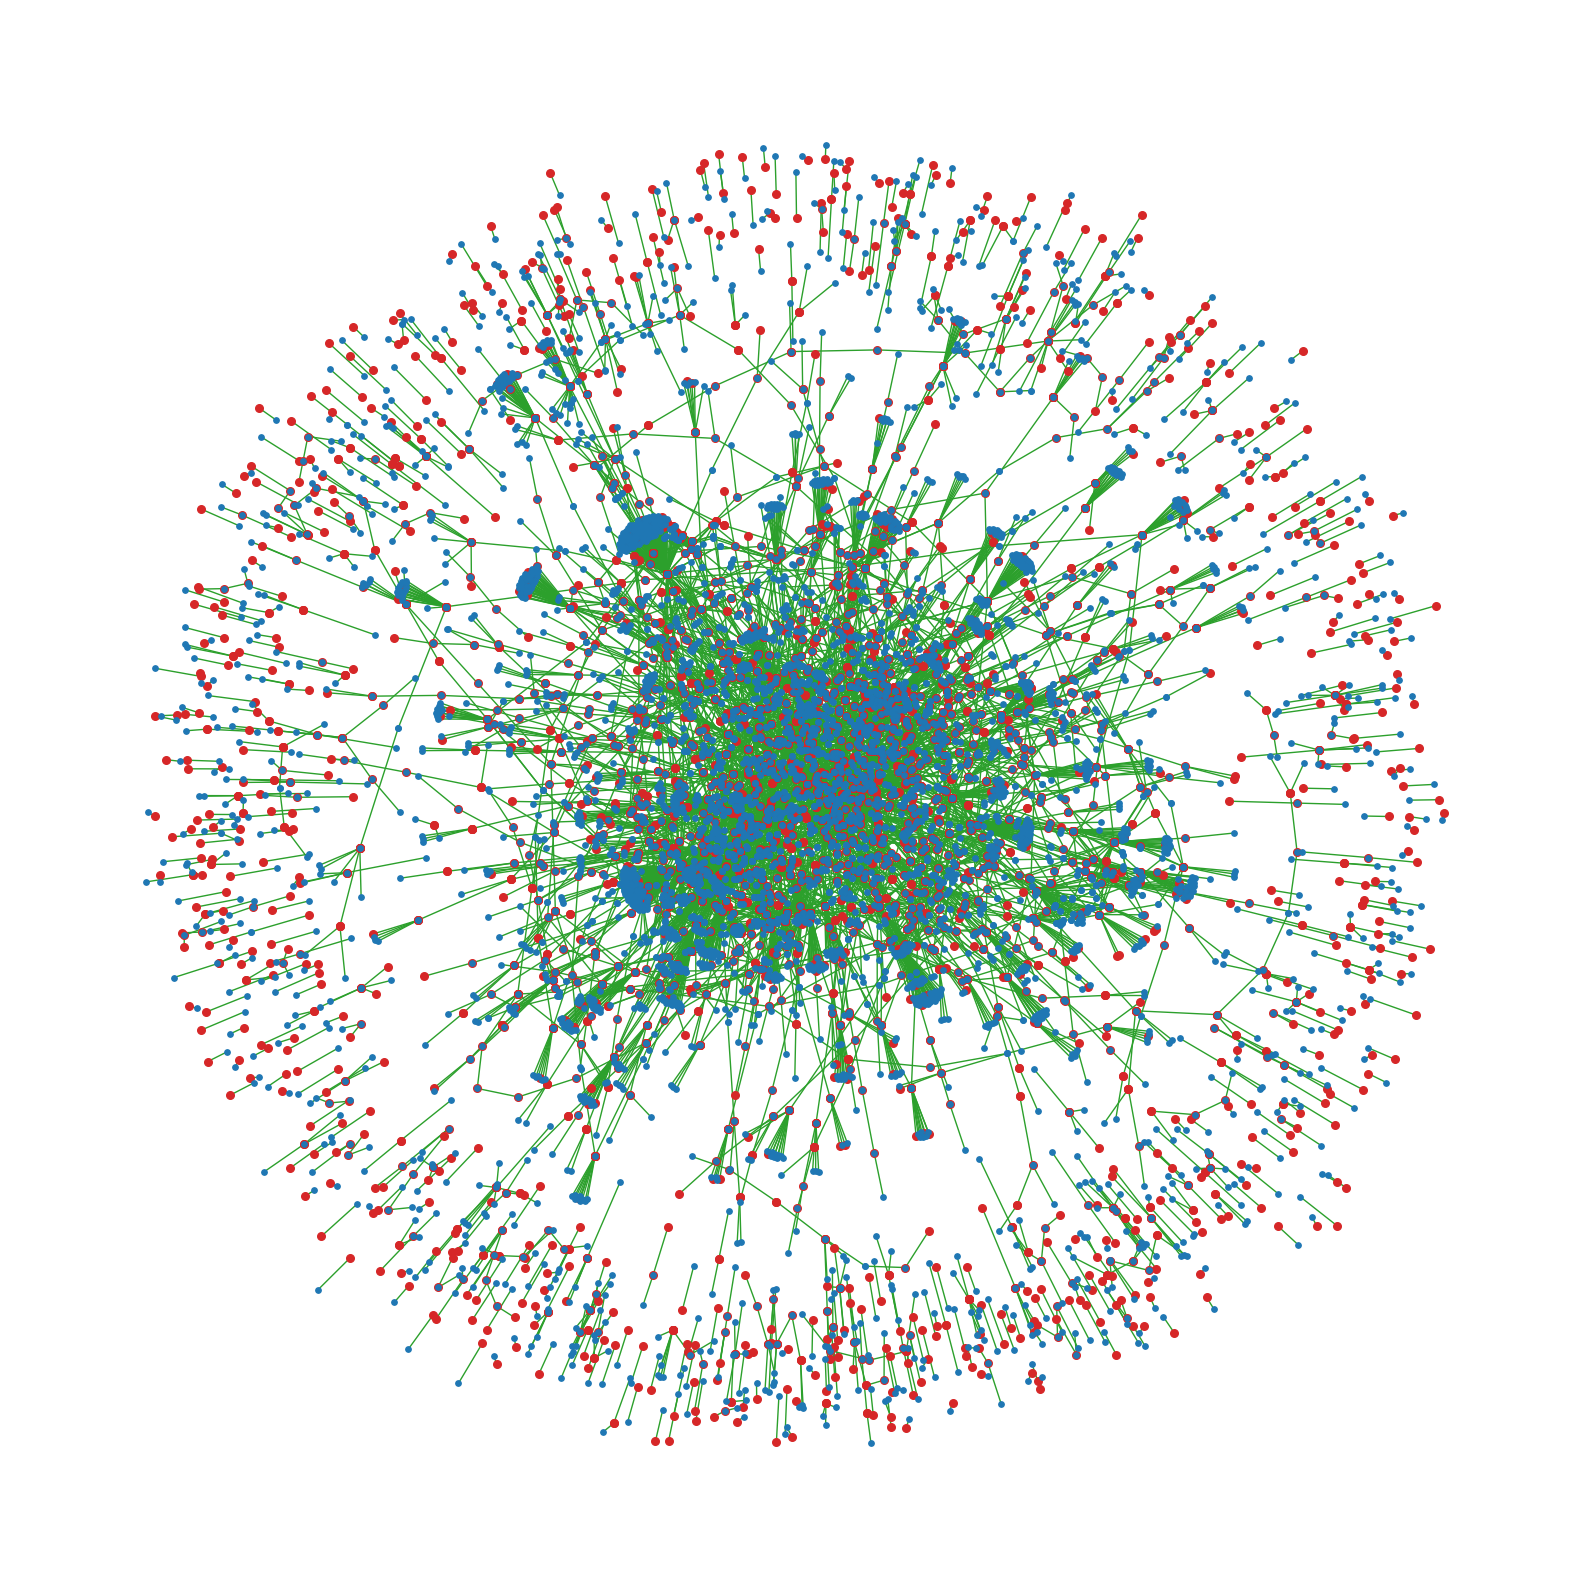

In [19]:
G_edge_lst = list(G.edges())

s_id_lst = [] 
i_id_lst = []
for e in G_edge_lst:
    s_id_lst.append(e[0])
    i_id_lst.append(e[1])

G_s = nx.Graph()
G_i = nx.Graph()
G_t = nx.Graph()

G_s.add_nodes_from(s_id_lst)
G_i.add_nodes_from(i_id_lst)
G_t.add_nodes_from([G_s, G_i])

#G_t.add_nodes_from(G_i)

G_t.add_edges_from(G_edge_lst)

pos = nx.spring_layout(G_t, k=0.03, seed = random.randint(1,10e7))
#pos = nx.fruchterman_reingold_layout(G_t)

nx.draw_networkx_nodes(G_t, pos, nodelist=s_id_lst, node_size=30, node_color="tab:red")
nx.draw_networkx_nodes(G_t, pos, nodelist=i_id_lst, node_size=15, node_color="tab:blue")
nx.draw_networkx_edges(G_t, pos, node_size=20, edge_color="tab:green")

plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['figure.autolayout'] = True
plt.tight_layout()
plt.figure(1, figsize=(20,20))
plt.axis("off")
plt.show()

In [35]:
c= nx.degree_centrality(G_t)

In [36]:
c_keys = list(c.keys())
c_values = list(c.values())

In [42]:
max(c_values)

0.026856495712667853

In [48]:
G_t.number_of_edges()

7182

In [49]:
G_t.number_of_nodes()

6182

In [51]:
min(c_values), max(c_values)

(0.0, 0.026856495712667853)

In [56]:
idx = c_values.index(max(c_values))
c_keys[idx]

214821277

In [104]:
v_max = max(c_values)
c_idx = [c_values.index(x) for x in c_values if abs(x - v_max) <= v_max/1.1]

In [105]:
c_v = [c_values[x] for x in c_idx]

In [106]:
c_edges = list(np.rint(np.array(c_v) * G_t.number_of_edges()))

In [107]:
c_k = [c_keys[x] for x in c_idx]

In [108]:
for i in range(len(c_k)):
    print('node ID: {} has {} edges'.format(c_k[i], c_edges[i]))

node ID: 214834865 has 33.0 edges
node ID: 214716932 has 35.0 edges
node ID: 214840483 has 56.0 edges
node ID: 214820392 has 21.0 edges
node ID: 214748293 has 20.0 edges
node ID: 214820231 has 36.0 edges
node ID: 214820392 has 21.0 edges
node ID: 214821277 has 193.0 edges
node ID: 214684513 has 42.0 edges
node ID: 214826705 has 76.0 edges
node ID: 214840483 has 56.0 edges
node ID: 214821285 has 89.0 edges
node ID: 214821290 has 81.0 edges
node ID: 214826801 has 99.0 edges
node ID: 214832557 has 52.0 edges
node ID: 214585395 has 31.0 edges
node ID: 214753507 has 44.0 edges
node ID: 214820392 has 21.0 edges
node ID: 214716930 has 43.0 edges
node ID: 214840762 has 58.0 edges
node ID: 214586711 has 19.0 edges
node ID: 214839313 has 170.0 edges
node ID: 214716932 has 35.0 edges
node ID: 214820392 has 21.0 edges
node ID: 214832653 has 24.0 edges
node ID: 214748293 has 20.0 edges
node ID: 214826816 has 30.0 edges
node ID: 214826608 has 53.0 edges
node ID: 214664919 has 22.0 edges
node ID: 214